Imports.

In [1]:
import numpy as np

import pandas as pd

from ast import literal_eval

from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

Load `chaps_df` and undo array-to-list.

In [2]:
chaps_df = pd.read_csv('../data/animorphs_chaps.csv')

for col in ['clean','clean_no_stops', 'vec_clean']:
    chaps_df[col] = chaps_df[col].map(literal_eval) # as lists
    
for col in ['vec_clean']:
    chaps_df[col] = chaps_df[col].map(np.array) # as array
    
chaps_df.head()

,book,chapter,text,authenticity,clean,clean_no_stops,vec_clean
0,1,1,"My name is Jake. That's my first name, obvious...",1,"[name, thats, first, name, obviously, cant, te...","[my, name, is, jake, thats, my, first, name, o...","[0.050813198, 0.21546867, -0.11217794, 0.05301..."
1,1,2,"""A flying saucer?"" Marco said. He did laugh. T...",1,"[flying, saucer, qstinpunc, laugh, looked, cou...","[a, flying, saucer, qstinpunc, marco, said, he...","[0.0059409393, 0.23846294, -0.09167185, 0.0067..."
2,1,3,<They have come to destroy you.>\nIt was stran...,1,"[anglepunc, come, destroy, anglepunc, strange,...","[anglepunc, they, have, come, to, destroy, you...","[0.00516426, 0.25513598, -0.040639274, -0.0519..."
3,1,4,<Yeerks!>\nThe twin red lights slowed. They tu...,1,"[anglepunc, yeerks, exclmpunc, anglepunc, twin...","[anglepunc, yeerks, exclmpunc, anglepunc, the,...","[-0.027513022, 0.24088845, 0.00715725, -0.0299..."
4,1,5,"The Hork-Bajir pointed his gun, or whatever it...",1,"[hork, odashpunc, bajir, pointed, gun, whateve...","[the, hork, odashpunc, bajir, pointed, his, gu...","[-0.037028935, 0.29484826, 0.030976577, -0.076..."


Load `books_df` and undo array-to-list.

In [3]:
books_df = pd.read_csv('../data/animorphs_books.csv')

for col in ['book_vec']:
    books_df[col] = books_df[col].map(literal_eval) # as lists
    
for col in ['book_vec']:
    books_df[col] = books_df[col].map(np.array) # as array
    
books_df.head()

,book,text,authenticity,clean,book_vec
0,1,"My name is Jake. That's my first name, obvious...",1,"['name', 'thats', 'first', 'name', 'obviously'...","[0.0010895184, 0.2081184, -0.05931624, 0.01286..."
1,2,My name is Rachel. I won't tell you my last na...,1,"['name', 'tell', 'last', 'name', 'none', 'us',...","[-0.00226549, 0.22271992, -0.065148115, 0.0113..."
2,3,My name is Tobias. A freak of nature. One of a...,1,"['name', 'freak', 'nature', 'kind', 'tell', 'l...","[-0.0129256295, 0.21558568, -0.05230921, 0.003..."
3,4,My name is Cassie.\nI can't tell you my last n...,1,"['name', 'cant', 'tell', 'last', 'name', 'wish...","[-0.0025382496, 0.21817772, -0.069260634, 0.00..."
4,5,My name is Marco.\nI can't tell you my last na...,1,"['name', 'cant', 'tell', 'last', 'name', 'live...","[-0.00024333985, 0.22410813, -0.054545447, 0.0..."


Modeling.

In [4]:
seed = 1007
cv_times = 5

A manual, not-cross-validated gridsearch. This is desirable because of our leave-one-out training, which will be detailed ahead.

In [5]:
def do_gs(model, params, X, y): # do gridsearch
    # adapted from David at https://stackoverflow.com/questions/34624978
    
    best_score = -1
    best_p = {}
    
    for p in ParameterGrid(params):
        
        model.set_params(**p)
        model.fit(X,y)
        
        if model.score(X,y) > best_score:
            best_score = model.score(X,y)
            best_p = p
            
    model.set_params(**best_p)
    model.fit(X,y)
    
    return model

Generate results using leave-one-out training—each book's results are generated by a model trained on all other books. We have two different functions to get these results: one operates on books as wholes, the other averages chapters of specific books.

In [6]:
def pred_one_out_b(book_out, model, params, books_df=books_df):

    train_inds = books_df['book'] != book_out
    test_inds = books_df['book'] == book_out
    
    X_b = pd.DataFrame(list(books_df['book_vec'])).loc[train_inds]
    y_b = books_df['authenticity'].loc[train_inds]
    
    X_b_test = pd.DataFrame(list(books_df['book_vec'])).loc[test_inds]
    
    ss = StandardScaler()
    X_b = ss.fit_transform(X_b)
    X_b_test = ss.transform(X_b_test)

    model = do_gs(model, params, X_b, y_b)
    return (model.predict_proba(X_b_test)[:,1][0])

In [7]:
def pred_one_out_c(book_out, model, params, chaps_df=chaps_df):

    train_inds = chaps_df['book'] != book_out
    test_inds = chaps_df['book'] == book_out
    
    X_c = pd.DataFrame(list(chaps_df['vec_clean'])).loc[train_inds]
    y_c = chaps_df['authenticity'].loc[train_inds]
    
    X_c_test = pd.DataFrame(list(chaps_df['vec_clean'])).loc[test_inds]
    
    ss = StandardScaler()
    X_c = ss.fit_transform(X_c)
    X_c_test = ss.transform(X_c_test)

    model = do_gs(model, params, X_c, y_c)
    print(f'book {book_out} complete')
    return (np.mean(model.predict(X_c_test)), 
            np.mean(model.predict_proba(X_c_test)[:,1]))

In [8]:
svm_params = {
    'C':np.logspace(2,4,5),
    'kernel':['rbf']
}
svm = SVC(random_state=seed, gamma='scale',
          max_iter=5e4, probability=True)

In [9]:
results = pd.DataFrame({'book':range(1,55)})
results['w2vsvm book pred proba'] = results['book'].map(
    lambda b:pred_one_out_b(b, svm, svm_params))
temp_c = results['book'].map(lambda b:pred_one_out_c(b, svm, svm_params))
results['w2vsvm chap pred avg'] = temp_c.map(lambda p:p[0])
results['w2vsvm chap pred proba avg'] = temp_c.map(lambda p:p[1])

book 1 complete
book 2 complete
book 3 complete
book 4 complete
book 5 complete
book 6 complete
book 7 complete
book 8 complete
book 9 complete
book 10 complete
book 11 complete
book 12 complete
book 13 complete
book 14 complete
book 15 complete
book 16 complete
book 17 complete
book 18 complete
book 19 complete
book 20 complete
book 21 complete
book 22 complete
book 23 complete
book 24 complete
book 25 complete
book 26 complete
book 27 complete
book 28 complete
book 29 complete
book 30 complete
book 31 complete
book 32 complete
book 33 complete
book 34 complete
book 35 complete
book 36 complete
book 37 complete
book 38 complete
book 39 complete
book 40 complete
book 41 complete
book 42 complete
book 43 complete
book 44 complete
book 45 complete
book 46 complete
book 47 complete
book 48 complete
book 49 complete
book 50 complete
book 51 complete
book 52 complete
book 53 complete
book 54 complete


In [10]:
results['authenticity'] = books_df['authenticity']

In [11]:
results.to_csv('../data/results.csv', index=False)

In [12]:
def col_acc(col):
    return 1 - np.mean(
        (results['authenticity']-results[col].map(np.round)
        ).map(lambda a:abs(int(a)))
    )

In [13]:
col_acc('w2vsvm chap pred avg'), col_acc('w2vsvm chap pred proba avg'), \
    col_acc('w2vsvm book pred proba')

(0.8703703703703703, 0.8703703703703703, 0.8518518518518519)

In [14]:
def inacc_set(col, results=results):
    return set(
        results[np.round(results[col]) != results['authenticity']].index+1)

inacc_set('w2vsvm chap pred avg'), inacc_set('w2vsvm chap pred proba avg'), \
    inacc_set('w2vsvm book pred proba')

({25, 26, 29, 32, 34, 53, 54},
 {25, 28, 29, 34, 50, 53, 54},
 {24, 25, 26, 34, 48, 50, 53, 54})

In [15]:
bads = sorted(list(inacc_set('w2vsvm book pred proba') |
                   inacc_set('w2vsvm chap pred proba avg') |
                   inacc_set('w2vsvm chap pred avg')))
bads

[24, 25, 26, 28, 29, 32, 34, 48, 50, 53, 54]

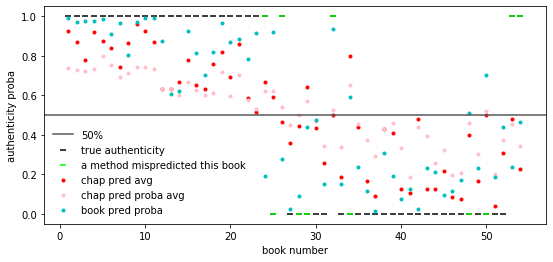

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,4))
plt.axhline(.5,c='#555555')
plt.scatter(range(1,55),results['authenticity'],
            c='k', marker='_')
plt.scatter(bads, results.loc[results['book'].map(lambda b: b in bads),
                              'authenticity'],
            c='lime', marker='_', alpha=1)
plt.scatter(range(1,55),results['w2vsvm chap pred avg'],
            c='r', marker='.')
plt.scatter(range(1,55),results['w2vsvm chap pred proba avg'],
            c='pink', marker='.')
plt.scatter(range(1,55),results['w2vsvm book pred proba'], 
            c='c', marker='.')
plt.legend(['50%','true authenticity', 'a method mispredicted this book',
            'chap pred avg','chap pred proba avg','book pred proba'],
           fancybox=True, framealpha=0)
plt.xlabel('book number')
plt.ylabel('authenticity proba')
plt.savefig('../figures/svm_results.png');

This is strong evidence **against** this method of inquiry with regard to these texts. We know that most authentic Animorphs books are early on in the series, and most ghostwritten books are later. However, even within the ghostwriter-free section at the beginning of the series, our model trends away from maximum probability of authenticity over time.

Because the themes and topics of the series changed over time, I suspect that our models are better at recognizing content differences than author differences—they identify a *content shift* rather than an *author shift* or *style shift* in the early non-ghostwritten section, and the books that they fail to accurately predict are those unusually placed, chronologically. This is strong evidence that this method simply isn't cleanly picking up on authorship or style, and is thus inappropriate for determining author authenticity on this dataset.

After reading [these](https://pdfs.semanticscholar.org/3fd9/c3a45629393465e7258dee0f1eaab32ea4bc.pdf) [papers](https://www.aclweb.org/anthology/Q15-1016.pdf), I have become skeptical of the ability of conceptual vectorizations such as word2vec in determining true authorship, especially when the corpus influences it to respond more to author-agnostic content than to style.

Because Word2Vec analysis seems unfruitful, I will treat this as my baseline and attempt some more traditional stylometric analyses that are clearly geared toward style rather than content.